## Introduction

In this notebook we're going to build and train a deep learning model "from scratch" -- by which I mean that we're not going to use any pre-built architecture, or optimizers, or data loading frameworks, etc.

We'll be assuming you already know the basics of how a neural network works. If you don't, read this notebook first: [How does a neural net really work?
](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work). We'll be using Kaggle's [Titanic](https://www.kaggle.com/competitions/titanic/) competition in this notebook, because it's very small and simple, but also has displays many of the tricky real-life issues that we need to handle in most practical projects. (Note, however, that this competition is a small "learner" competition on Kaggle, so don't expect to actually see much benefits from using a neural net just yet; that will come once we try our some real competitions!)

It's great to be able to run the same notebook on your own machine or Colab, as well as Kaggle. To allow for this, we use this code to download the data as needed when not on Kaggle (see [this notebook](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners/) for details about this technique):

In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/digit-recognizer')
else:
    path = Path('digit-recognizer')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 15.3M/15.3M [00:04<00:00, 3.36MB/s]


Note that the data for Kaggle comps always lives in the `../input` folder. The easiest way to get the path is to click the "K" button in the top-right of the Kaggle notebook, click on the folder shown there, and click the copy button.

We'll be using *numpy* and *pytorch* for array calculations in this notebook, and *pandas* for working with tabular data, so we'll import them and set them to display using a bit more space than they default to.

In [54]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Cleaning the data

This is a *tabular data* competition -- the data is in the form of a table. It's provided as a Comma Separated Values (CSV) file. We can open it using the *pandas* library, which will create a `DataFrame`.

In [56]:
df = pd.read_csv(path/'train.csv')
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here's how we get a quick summary of all the numeric columns in the dataset:

In [57]:
import numpy as np

df.describe(include=(np.number))

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


Now we can create our independent (predictors) and dependent (target) variables. They both need to be PyTorch tensors. Our dependent variable is `label`:

In [59]:
from torch import tensor

t_dep = tensor(df.label)
t_dep

tensor([1, 0, 1, 4, 0, 0, 7,  ..., 6, 4, 0, 1, 7, 6, 9])

Our independent variables are all the continuous variables of interest plus all the dummy variables we just created:

In [60]:
df.drop('label',axis=1)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
indep_vars = df.drop('label',axis=1)
t_indep = tensor(indep_vars.values, dtype=torch.float)
t_indep

tensor([[0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,  ..., 0., 0., 

In [62]:
t_indep.shape

torch.Size([42000, 784])

## Setting up a linear model

Now that we've got a matrix of independent variables and a dependent variable vector, we can work on calculating our predictions and our loss. In this section, we're going to manually do a single step of calculating predictions and loss for every row of our data.

Our first model will be a simple linear model. We'll need a coefficient for each column in `t_indep`. We'll pick random numbers in the range `(-0.5,0.5)`, and set our manual seed so that my explanations in the prose in this notebook will be consistent with what you see when you run it.

In [63]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([    -0.4629,      0.1386,      0.2409,     -0.2262,     -0.2632,     -0.3147,      0.4876,      0.3136,      0.2799,     -0.4392,
             0.2103,      0.3625,      0.1722,      0.2324,     -0.3575,     -0.0010,     -0.1833,     -0.2411,      0.0489,      0.0866,
            -0.0534,      0.3132,     -0.1487,     -0.2551,      0.3328,      0.1292,      0.2361,     -0.2622,      0.4051,     -0.2674,
            -0.2312,      0.1147,      0.4072,      0.2834,      0.0835,     -0.0504,      0.4354,     -0.3408,     -0.4552,      0.1447,
            -0.4648,     -0.3039,     -0.1297,     -0.0850,      0.4682,      0.3973,     -0.4849,      0.2098,     -0.3018,      0.4185,
             0.1089,      0.0791,     -0.1708,     -0.1882,      0.4861,     -0.2534,     -0.2502,     -0.0770,      0.3336,     -0.4975,
            -0.2561,      0.0892,     -0.4670,      0.3725,     -0.1095,      0.3443,     -0.3448,      0.1112,     -0.2866,      0.0245,
            -0.1640,     -0.0845, 

Our predictions will be calculated by multiplying each row by the coefficients, and adding them up. One interesting point here is that we don't need a separate constant term (also known as a "bias" or "intercept" term), or a column of all `1`s to give the same effect has having a constant term. That's because our dummy variables already cover the entire dataset -- e.g. there's a column for "male" and a column for "female", and everyone in the dataset is in exactly one of these; therefore, we don't need a separate intercept term to cover rows that aren't otherwise part of a column.

Here's what the multiplication looks like:

In [64]:
t_indep*coeffs

tensor([[-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        ...,
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0

We can see we've got a problem here. The sums of each row will be dominated by the first column, which is `Age`, since that's bigger on average than all the others.

Let's make all the columns contain numbers from `0` to `1`, by dividing each column by its `max()`:

In [71]:
vals,indices = t_indep.max(dim=0)
print(vals)
# Avoid division by zero by setting zero max values to one (or some other non-zero value)
safe_vals = torch.where(vals == 0.0, torch.tensor(1.0), vals)
t_indep = t_indep / safe_vals

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 116., 254., 216.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  16.,  47., 157., 254., 255., 243., 255., 255., 255., 255., 255., 255.,
        255., 255., 255., 255., 244., 255., 184., 197.,   0.,   0.,   0.,   0.,   0.,   0.,  64.,  29., 134., 128., 234., 255., 255., 255.,
        255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 165.,   0.,   0.,   0.,   0., 141.,  84.,
        139., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 164.,
        121.,   0.,   0.,  38.,  51., 114., 226., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255., 255., 255., 255., 254., 230.,   0.,   0.,   0.,  95., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255., 

As we see, that removes the problem of one column dominating all the others:

In [72]:
t_indep*coeffs

tensor([[-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        ...,
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0., 0., -0., -0., -0., 0.,  ..., -0., -0., -0., -0., 0., 0., -0.],
        [-0., 0

One thing you hopefully noticed is how amazingly cool this line of code is:

    t_indep = t_indep / vals

That is dividing a matrix by a vector -- what on earth does that mean?!? The trick here is that we're taking advantage of a technique in numpy and PyTorch (and many other languages, going all the way back to APL) called [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html). In short, this acts as if there's a separate copy of the vector for every row of the matrix, so it divides each row of the matrix by the vector. In practice, it doesn't actually make any copies, and does the whole thing in a highly optimized way, taking full advantage of modern CPUs (or, indeed, GPUs, if we're using them). Broadcasting is one of the most important techniques for making your code concise, maintainable, and fast, so it's well worth studying and practicing.

We can now create predictions from our linear model, by adding up the rows of the product:

In [73]:
preds = (t_indep*coeffs).sum(axis=1)

Let's take a look at the first few:

In [74]:
preds[:10]

tensor([-4.7737,  3.3516, -0.1378, -1.7691,  0.5001,  0.3763,  0.1946, -0.7404,  2.9025, -0.8442])

Of course, these predictions aren't going to be any use, since our coefficients are random -- they're just a starting point for our gradient descent process.

To do gradient descent, we need a loss function. Taking the average error of the rows (i.e. the absolute value of the difference between the prediction and the dependent) is generally a reasonable approach:

In [75]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(4.3207)

Now that we've tested out a way of calculating predictions, and loss, let's pop them into functions to make life easier:

In [76]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Doing a gradient descent step

In this section, we're going to do a single "epoch" of gradient descent manually. The only thing we're going to automate is calculating gradients, because let's face it that's pretty tedious and entirely pointless to do by hand! To get PyTorch to calculate gradients, we'll need to call `requires_grad_()` on our `coeffs` (if you're not sure why, review the previous notebook, [How does a neural net really work?](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work), before continuing):

In [77]:
coeffs.requires_grad_()

tensor([    -0.4629,      0.1386,      0.2409,     -0.2262,     -0.2632,     -0.3147,      0.4876,      0.3136,      0.2799,     -0.4392,
             0.2103,      0.3625,      0.1722,      0.2324,     -0.3575,     -0.0010,     -0.1833,     -0.2411,      0.0489,      0.0866,
            -0.0534,      0.3132,     -0.1487,     -0.2551,      0.3328,      0.1292,      0.2361,     -0.2622,      0.4051,     -0.2674,
            -0.2312,      0.1147,      0.4072,      0.2834,      0.0835,     -0.0504,      0.4354,     -0.3408,     -0.4552,      0.1447,
            -0.4648,     -0.3039,     -0.1297,     -0.0850,      0.4682,      0.3973,     -0.4849,      0.2098,     -0.3018,      0.4185,
             0.1089,      0.0791,     -0.1708,     -0.1882,      0.4861,     -0.2534,     -0.2502,     -0.0770,      0.3336,     -0.4975,
            -0.2561,      0.0892,     -0.4670,      0.3725,     -0.1095,      0.3443,     -0.3448,      0.1112,     -0.2866,      0.0245,
            -0.1640,     -0.0845, 

Now when we calculate our loss, PyTorch will keep track of all the steps, so we'll be able to get the gradients afterwards:

In [78]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(4.3207, grad_fn=<MeanBackward0>)

Use `backward()` to ask PyTorch to calculate gradients now:

In [79]:
loss.backward()

Let's see what they look like:

In [80]:
coeffs.grad

tensor([     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,     -0.0000,     -0.0000,     -0.0001,     -0.0001,     -0.0002,     -0.0003,     -0.0005,     -0.0007,
            -0.0008,     -0.0007,     -0.0007,     -0.0006,     -0.0005,     -0.0005,     -0.0004,     -0.0002,     -0.0002,     -0.0001,
            -0.0001,     -0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,     -0.0000,      0.0000,
            -0.0001,     -0.0000,     -0.0002,     -0.0005,     -0.0010,     -0.0019,     -0.0031,     -0.0049,     -0.0071,     -0.0096,
            -0.0121,     -0.0130, 

Note that each time we call `backward`, the gradients are actually *added* to whatever is in the `.grad` attribute. Let's try running the above steps again:

In [81]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,     -0.0001,     -0.0001,     -0.0000,     -0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,     -0.0000,     -0.0001,     -0.0001,     -0.0002,     -0.0004,     -0.0005,     -0.0010,     -0.0014,
            -0.0015,     -0.0015,     -0.0015,     -0.0012,     -0.0010,     -0.0010,     -0.0008,     -0.0005,     -0.0004,     -0.0001,
            -0.0001,     -0.0001,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,     -0.0000,      0.0000,
            -0.0001,     -0.0001,     -0.0004,     -0.0009,     -0.0021,     -0.0038,     -0.0062,     -0.0097,     -0.0142,     -0.0193,
            -0.0243,     -0.0261, 

As you see, our `.grad` values are have doubled. That's because it added the gradients a second time. For this reason, after we use the gradients to do a gradient descent step, we need to set them back to zero.

We can now do one gradient descent step, and check that our loss decreases:

In [82]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(4.4487)


Note that `a.sub_(b)` subtracts `b` from `a` in-place. In PyTorch, any method that ends in `_` changes its object in-place. Similarly, `a.zero_()` sets all elements of a tensor to zero.

## Training the linear model

Before we begin training our model, we'll need to ensure that we hold out a validation set for calculating our metrics (for details on this, see "[Getting started with NLP for absolute beginners](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners#Test-and-validation-sets)".

There's lots of different ways we can do this. In the next notebook we'll be comparing our approach here to what the fastai library does, so we'll want to ensure we split the data in the same way. So let's use `RandomSplitter` to get indices that will split our data into training and validation sets:

In [83]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

Now we can apply those indicies to our independent and dependent variables:

In [84]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(33600, 8400)

We'll create functions for the three things we did manually above: updating `coeffs`, doing one full gradient descent step, and initilising `coeffs` to random numbers:

In [85]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [86]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [87]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

We can now use these functions to train our model:

In [88]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

Let's try it. Our loss will print at the end of every step, so we hope we'll see it going down:

In [90]:
coeffs = train_model(18, lr=0.1)

4.311; 2.890; 2.667; 2.586; 2.515; 2.451; 2.394; 2.342; 2.295; 2.254; 2.216; 2.183; 2.152; 2.125; 2.100; 2.078; 2.059; 2.041; 

It does!

Let's take a look at the coefficients for each column:

In [91]:
def show_coeffs(): return dict(zip(indep_vars.columns, coeffs.requires_grad_(False)))
show_coeffs()

{'pixel0': tensor(-0.4629),
 'pixel1': tensor(0.1386),
 'pixel2': tensor(0.2409),
 'pixel3': tensor(-0.2262),
 'pixel4': tensor(-0.2632),
 'pixel5': tensor(-0.3147),
 'pixel6': tensor(0.4876),
 'pixel7': tensor(0.3136),
 'pixel8': tensor(0.2799),
 'pixel9': tensor(-0.4392),
 'pixel10': tensor(0.2103),
 'pixel11': tensor(0.3625),
 'pixel12': tensor(0.1722),
 'pixel13': tensor(0.2325),
 'pixel14': tensor(-0.3575),
 'pixel15': tensor(-0.0010),
 'pixel16': tensor(-0.1833),
 'pixel17': tensor(-0.2411),
 'pixel18': tensor(0.0489),
 'pixel19': tensor(0.0866),
 'pixel20': tensor(-0.0534),
 'pixel21': tensor(0.3132),
 'pixel22': tensor(-0.1487),
 'pixel23': tensor(-0.2551),
 'pixel24': tensor(0.3328),
 'pixel25': tensor(0.1292),
 'pixel26': tensor(0.2361),
 'pixel27': tensor(-0.2622),
 'pixel28': tensor(0.4051),
 'pixel29': tensor(-0.2674),
 'pixel30': tensor(-0.2312),
 'pixel31': tensor(0.1147),
 'pixel32': tensor(0.4073),
 'pixel33': tensor(0.2835),
 'pixel34': tensor(0.0836),
 'pixel35': ten

## Measuring accuracy

The Kaggle competition is not, however, scored by absolute error (which is our loss function). It's scored by *accuracy* -- the proportion of rows where we correctly predict survival. Let's see how accurate we were on the validation set. First, calculate the predictions:

In [97]:
preds = calc_preds(coeffs, val_indep)
print(val_dep)
torch.round(preds)

tensor([6, 3, 6, 1, 7, 9, 1,  ..., 3, 8, 3, 5, 4, 6, 3])


tensor([ 4.,  2.,  3.,  2.,  6.,  8.,  3.,  ..., -1.,  7.,  5.,  2.,  9.,  5.,  1.])

We'll assume that any passenger with a score of over `0.5` is predicted to survive. So that means we're correct for each row where `preds>0.5` is the same as the dependent variable:

In [96]:
results = torch.eq(val_dep, torch.round(preds))
results[:16]

tensor([False, False, False, False, False, False, False, False, False,  True,  True, False, False, False, False, False])

Let's see what our average accuracy is:

In [98]:
results.float().mean()

tensor(0.1673)

That's not a bad start at all! We'll create a function so we can calcuate the accuracy easy for other models we train:

In [99]:
def acc(coeffs): return (torch.eq(val_dep, torch.round(calc_preds(coeffs, val_indep)))).float().mean()
acc(coeffs)

tensor(0.1673)

## Using sigmoid

Looking at our predictions, there's one obvious problem -- some of our predictions of the probability of survival are `>1`, and some are `<0`:

In [100]:
preds[:28]

tensor([4.2534, 2.1610, 3.4290, 1.8156, 5.9058, 7.5189, 3.1806, 3.4630, 4.5087, 5.8910, 5.4332, 6.4932, 0.6244, 5.2409, 1.7034, 5.3738,
        3.7018, 5.2964, 3.5246, 0.8176, 6.1915, 2.9467, 2.4050, 6.3866, 7.0920, 7.9649, 7.4542, 5.4504])

To fix this, we should pass every prediction through the *sigmoid function*, which has a minimum at zero and maximum at one, and is defined as follows:

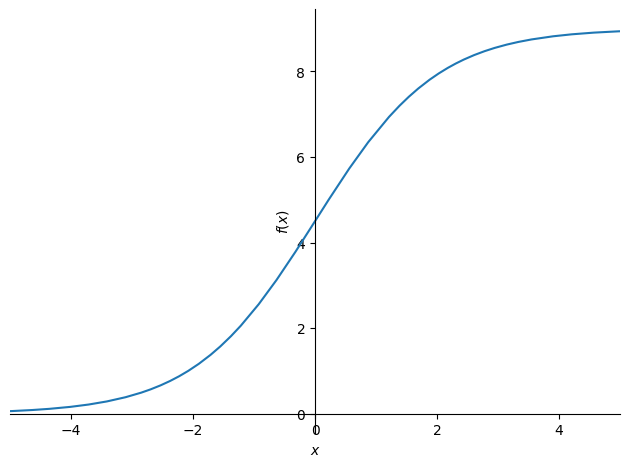

In [103]:
import sympy
sympy.plot("9/(1+exp(-x))", xlim=(-5,5));

PyTorch already defines that function for us, so we can modify `calc_preds` to use it:

In [104]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))*9

Let's train a new model now, using this updated function to calculate predictions:

In [106]:
coeffs = train_model(lr=0.1)

2.956; 2.858; 2.771; 2.689; 2.611; 2.538; 2.469; 2.406; 2.347; 2.295; 2.248; 2.206; 2.169; 2.136; 2.107; 2.082; 2.059; 2.038; 2.020; 2.003; 1.988; 1.975; 1.962; 1.950; 1.940; 1.930; 1.920; 1.911; 1.903; 1.895; 

The loss has improved by a lot. Let's check the accuracy:

In [107]:
acc(coeffs)

tensor(0.2426)

That's improved too! Here's the coefficients of our trained model:

In [108]:
show_coeffs()

{'pixel0': tensor(-0.4629),
 'pixel1': tensor(0.1386),
 'pixel2': tensor(0.2409),
 'pixel3': tensor(-0.2262),
 'pixel4': tensor(-0.2632),
 'pixel5': tensor(-0.3147),
 'pixel6': tensor(0.4876),
 'pixel7': tensor(0.3136),
 'pixel8': tensor(0.2799),
 'pixel9': tensor(-0.4392),
 'pixel10': tensor(0.2103),
 'pixel11': tensor(0.3625),
 'pixel12': tensor(0.1724),
 'pixel13': tensor(0.2326),
 'pixel14': tensor(-0.3575),
 'pixel15': tensor(-0.0010),
 'pixel16': tensor(-0.1833),
 'pixel17': tensor(-0.2411),
 'pixel18': tensor(0.0489),
 'pixel19': tensor(0.0866),
 'pixel20': tensor(-0.0534),
 'pixel21': tensor(0.3132),
 'pixel22': tensor(-0.1487),
 'pixel23': tensor(-0.2551),
 'pixel24': tensor(0.3328),
 'pixel25': tensor(0.1292),
 'pixel26': tensor(0.2361),
 'pixel27': tensor(-0.2622),
 'pixel28': tensor(0.4051),
 'pixel29': tensor(-0.2674),
 'pixel30': tensor(-0.2312),
 'pixel31': tensor(0.1147),
 'pixel32': tensor(0.4072),
 'pixel33': tensor(0.2834),
 'pixel34': tensor(0.0837),
 'pixel35': ten

These coefficients seem reasonable -- in general, older people and males were less likely to survive, and first class passengers were more likely to survive.

## Submitting to Kaggle

Now that we've got a trained model, we can prepare a submission to Kaggle. To do that, first we need to read the test set:

In [78]:
tst_df = pd.read_csv(path/'test.csv')

In this case, it turns out that the test set is missing `Fare` for one passenger. We'll just fill it with `0` to avoid problems:

In [79]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

Now we can just copy the same steps we did to our training set and do the same exact things on our test set to preprocess the data:

In [80]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])


# Convert all boolean columns to integers
tst_df = tst_df.astype({col: int for col in tst_df.select_dtypes(include='bool').columns})

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

Let's calculate our predictions of which passengers survived in the test set:

In [81]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

The sample submission on the Kaggle competition site shows that we're expected to upload a CSV with just `PassengerId` and `Survived`, so let's create that and save it:

In [82]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

We can check the first few rows of the file to make sure it looks reasonable:

In [83]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


When you click "save version" in Kaggle, and wait for the notebook to run, you'll see that `sub.csv` appears in the "Data" tab. Clicking on that file will show a *Submit* button, which allows you to submit to the competition.

## Using matrix product

We can make things quite a bit neater...

Take a look at the inner-most calculation we're doing to get the predictions:

In [109]:
(val_indep*coeffs).sum(axis=1)

tensor([-0.0108, -5.6278,  0.2997,  0.1003,  1.1623,  1.6804, -1.8950,  ..., -5.1155,  2.0699,  1.4349, -2.9620,  4.0186,  1.6766,
        -3.5795])

Multiplying elements together and then adding across rows is identical to doing a matrix-vector product! Python uses the `@` operator to indicate matrix products, and is supported by PyTorch tensors. Therefore, we can replicate the above calculate more simply like so:

In [110]:
val_indep@coeffs

tensor([-0.0108, -5.6278,  0.2997,  0.1003,  1.1623,  1.6804, -1.8950,  ..., -5.1155,  2.0699,  1.4349, -2.9620,  4.0186,  1.6766,
        -3.5795])

It also turns out that this is much faster, because matrix products in PyTorch are very highly optimised.

Let's use this to replace how `calc_preds` works:

In [111]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)*9

In order to do matrix-matrix products (which we'll need in the next section), we need to turn `coeffs` into a column vector (i.e. a matrix with a single column), which we can do by passing a second argument `1` to `torch.rand()`, indicating that we want our coefficients to have one column:

In [112]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

We'll also need to turn our dependent variable into a column vector, which we can do by indexing the column dimension with the special value `None`, which tells PyTorch to add a new dimension in this position:

In [113]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

We can now train our model as before and confirm we get identical outputs...:

In [121]:
coeffs = train_model(lr=0.1)

4.426; 4.395; 4.345; 4.255; 4.068; 3.621; 2.868; 2.633; 2.723; 2.819; 2.844; 2.526; 2.432; 2.553; 2.101; 2.244; 1.969; 2.156; 1.973; 2.209; 1.953; 2.124; 1.924; 2.067; 1.923; 2.047; 1.922; 2.013; 1.904; 1.971; 

...and identical accuracy:

In [122]:
acc(coeffs)

tensor(0.1827)

## A neural network

We've now got what we need to implement our neural network.

First, we'll need to create coefficients for each of our layers. Our first set of coefficients will take our `n_coeff` inputs, and create `n_hidden` outputs. We can choose whatever `n_hidden` we like -- a higher number gives our network more flexibility, but makes it slower and harder to train. So we need a matrix of size `n_coeff` by `n_hidden`. We'll divide these coefficients by `n_hidden` so that when we sum them up in the next layer we'll end up with similar magnitude numbers to what we started with.

Then our second layer will need to take the `n_hidden` inputs and create a single output, so that means we need a `n_hidden` by `1` matrix there. The second layer will also need a constant term added.

In [123]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

Now we have our coefficients, we can create our neural net. The key steps are the two matrix products, `indeps@l1` and `res@l2` (where `res` is the output of the first layer). The first layer output is passed to `F.relu` (that's our non-linearity), and the second is passed to `torch.sigmoid` as before.

In [124]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

Finally, now that we have more than one set of coefficients, we need to add a loop to update each one:

In [125]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

That's it -- we're now ready to train our model!

In [127]:
coeffs = train_model(lr=0.1)

3.868; 3.801; 3.746; 3.716; 3.698; 3.687; 3.679; 3.672; 3.668; 3.664; 3.662; 3.659; 3.658; 3.656; 3.655; 3.654; 3.653; 3.652; 3.651; 3.651; 3.650; 3.649; 3.649; 3.649; 3.648; 3.648; 3.647; 3.647; 3.647; 3.647; 

In [128]:
coeffs = train_model(lr=20)

3.868; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 

It's looking good -- our loss is lower than before. Let's see if that translates to a better result on the validation set:

In [129]:
acc(coeffs)

tensor(0.1113)

In this case our neural net isn't showing better results than the linear model. That's not surprising; this dataset is very small and very simple, and isn't the kind of thing we'd expect to see neural networks excel at. Furthermore, our validation set is too small to reliably see much accuracy difference. But the key thing is that we now know exactly what a real neural net looks like!

## Deep learning

The neural net in the previous section only uses one hidden layer, so it doesn't count as "deep" learning. But we can use the exact same technique to make our neural net deep, by adding more matrix multiplications.

First, we'll need to create additional coefficients for each layer:

In [43]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

You'll notice here that there's a lot of messy constants to get the random numbers in just the right ranges. When you train the model in a moment, you'll see that the tiniest changes to these initialisations can cause our model to fail to train at all! This is a key reason that deep learning failed to make much progress in the early days -- it's very finicky to get a good starting point for our coefficients. Nowadays, we have ways to deal with that, which we'll learn about in other notebooks.

Our deep learning `calc_preds` looks much the same as before, but now we loop through each layer, instead of listing them separately:

In [44]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

We also need a minor update to `update_coeffs` since we've got `layers` and `consts` separated now:

In [45]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Let's train our model...

In [46]:
coeffs = train_model(lr=4)

3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 3.639; 

...and check its accuracy:

In [48]:
acc(coeffs)

tensor(0.9007)

In [51]:
tst_indep = pd.read_csv(path/'test.csv')

In [52]:
tst_df['label'] = (calc_preds(tst_indep, coeffs)).int()

ValueError: too many values to unpack (expected 2)

## Final thoughts

It's actually pretty cool that we've managed to create a real deep learning model from scratch and trained it to get over 80% accuracy on this task, all in the course of a single notebook!

The "real" deep learning models that are used in research and industry look very similar to this, and in fact if you look inside the source code of any deep learning model you'll recognise the basic steps are the same.

The biggest differences in practical models to what we have above are:

- How initialisation and normalisation is done to ensure the model trains correctly every time
- Regularization (to avoid over-fitting)
- Modifying the neural net itself to take advantage of knowledge of the problem domain
- Doing gradient descent steps on smaller batches, rather than the whole dataset.

I'll be adding notebooks about all these later, and will add links here once they're ready.

If you found this notebook useful, please remember to click the little up-arrow at the top to upvote it, since I like to know when people have found my work useful, and it helps others find it too. (BTW, be sure you're looking at my [original notebook here](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch) when you do that, and are not on your own copy of it, otherwise your upvote won't get counted!) And if you have any questions or comments, please pop them below -- I read every comment I receive!